<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Before you start

In order to complete the project you will need to create a developer account with OpenAI and store your API key as a secure environment variable. Instructions for these steps are outlined below.

### Create a developer account with OpenAI

1. Go to the [API signup page](https://platform.openai.com/signup).

2. Create your account (you'll need to provide your email address and your phone number).

3. Go to the [API keys page](https://platform.openai.com/account/api-keys).

4. Create a new secret key.

<img src="images/openai-new-secret-key.png" width="200">

5. **Take a copy of it**. (If you lose it, delete the key and create a new one.)

### Add a payment method

OpenAI sometimes provides free credits for the API, but this can vary depending on geography. You may need to add debit/credit card details.

**This project should cost much less than 1 US cents with `gpt-4o-mini` (but if you rerun tasks, you will be charged every time).**

1. Go to the [Payment Methods page](https://platform.openai.com/account/billing/payment-methods).

2. Click Add payment method.

<img src="images/openai-add-payment-method.png" width="200">

3. Fill in your card details.

### Add an environmental variable with your OpenAI key

1. In the workbook, click on "Environment," in the top toolbar and select "Environment variables".

2. Click "Add" to add environment variables.

3. In the "Name" field, type "OPENAI_API_KEY". In the "Value" field, paste in your secret key.

<img src="images/datalab-env-var-details.png" width="500">

4. Click "Create", then you'll see the following pop-up window. Click "Connect," then wait 5-10 seconds for the kernel to restart, or restart it manually in the Run menu.

<img src="images/connect-integ.png" width="500">

### Update to Python 3.10

Due to how frequently the libraries required for this project are updated, you'll need to update your environment to Python 3.10:

1. In the workbook, click on "Environment," in the top toolbar and select "Session details".

2. In the workbook language dropdown, select "Python 3.10".

3. Click "Confirm" and hit "Done" once the session is ready.

## Load OpenAI API key from environment variables
These variables can be referenced globally throughout the project while keeping their values secret. Good for setting passwords in credentials.

In [1]:
!pip install python-dotenv

In [2]:
# Initialize your API key
import os
import dotenv
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai_api_key = os.environ["OPENAI_API_KEY"]

## Install useful libraries

In [3]:
# Update OpenAI to 1.3
!pip install --upgrade openai
import openai

In [4]:
!pip install --upgrade chromadb
!pip install --upgrade pysqlite3-binary
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [5]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [6]:
# Start coding here
# Use as many cells as you need.
#1. Part 1 - Raw dataset exploration
reviews.shape

(1000, 11)

In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Review ID                1000 non-null   int64 
 1   Clothing ID              1000 non-null   int64 
 2   Age                      1000 non-null   int64 
 3   Title                    810 non-null    object
 4   Review Text              958 non-null    object
 5   Rating                   1000 non-null   int64 
 6   Recommended IND          1000 non-null   int64 
 7   Positive Feedback Count  1000 non-null   int64 
 8   Division Name            1000 non-null   object
 9   Department Name          1000 non-null   object
 10  Class Name               1000 non-null   object
dtypes: int64(6), object(5)
memory usage: 86.1+ KB


In [8]:
reviews.iloc[0] #inspect a sample record

,0
Review ID,0
Clothing ID,767
Age,33
Title,NaN
Review Text,Absolutely wonderful - silky and sexy and comf...
Rating,4
Recommended IND,1
Positive Feedback Count,0
Division Name,Initmates
Department Name,Intimate


1. Import ChromaDB Dependencies to do this

In [9]:
import pandas as pd
#from chromadb import Client
#from chromadb.utils import embedding_functions

2. Preprocess the text to embed:

In [10]:
# Combine Division Name, Department Name, and Class Name into the Review Text
reviews["Enhanced Text"] = reviews.apply(
    lambda row: f"Review: {row['Review Text']} Division: {row['Division Name']}, "
                f"Department: {row['Department Name']}, Class: {row['Class Name']}",
    axis=1
)
reviews.iloc[0]

,0
Review ID,0
Clothing ID,767
Age,33
Title,NaN
Review Text,Absolutely wonderful - silky and sexy and comf...
Rating,4
Recommended IND,1
Positive Feedback Count,0
Division Name,Initmates
Department Name,Intimate


3. Preprocess data and meta-data for insertion into chromaDB

In [11]:
# Prepare data for insertion
documents = reviews["Enhanced Text"].fillna("").tolist()  # Embed enhanced review text
ids = reviews["Review ID"].astype(str).tolist()  # Use Review ID as unique identifiers
metadata = reviews.drop(columns=["Review Text", "Enhanced Text"]).to_dict(orient="records")  # All other fields as metadata


In [12]:
documents[0]

'Review: Absolutely wonderful - silky and sexy and comfortable Division: Initmates, Department: Intimate, Class: Intimates'

In [13]:
len(ids)

1000

In [14]:
metadata[0] #List of dictionaries containing meta-data about each review record

{'Review ID': 0,
 'Clothing ID': 767,
 'Age': 33,
 'Title': nan,
 'Rating': 4,
 'Recommended IND': 1,
 'Positive Feedback Count': 0,
 'Division Name': 'Initmates',
 'Department Name': 'Intimate',
 'Class Name': 'Intimates'}

4. Read in and embed the data into a chromaDB instance

In [15]:
#!pip show protobuf

In [16]:
#import google.protobuf
#print(google.protobuf.__file__)
#print(google.protobuf.__version__)

In [17]:
#!pip uninstall chromadb -y
#!pip install --no-cache-dir chromadb
#!pip install --upgrade chromadb

In [18]:
#from chromadb.api.types import IncludeEnum

#print("IncludeEnum imported successfully.")

In [19]:
import chromadb
from chromadb.config import Settings
from chromadb.utils import embedding_functions

# Define the OpenAI embedding function
openai_embed = embedding_functions.OpenAIEmbeddingFunction(
    model_name="text-embedding-3-small",
    api_key=openai_api_key
)

# Define persistent settings
#settings = Settings(
    #chroma_db_impl="duckdb+parquet",  # Use DuckDB with Parquet for persistence
    #persist_directory="db/"  # Directory for storing database files
#    is_persistent=False  # Disable persistence
#)

# Initialize ChromaDB client with consistent settings
#client = chromadb.Client(settings)
client = chromadb.Client()
# Create or get the collection
collection = client.get_or_create_collection(
    name="clothing_reviews",
    embedding_function=openai_embed
)

print("ChromaDB client and collection initialized successfully.")

ChromaDB client and collection initialized successfully.


In [20]:
collection

Collection(name=clothing_reviews)

5. Inspect the ChromaDB created collection

In [21]:
collection.count()

0

In [22]:
collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

6. Add the documents, IDs and Metadata

In [23]:
# Add data to the ChromaDB collection
collection.add(
    ids=ids,
    documents=documents,
    metadatas=metadata
)

print(f"Inserted {len(documents)} reviews into ChromaDB collection.")

Inserted 1000 reviews into ChromaDB collection.


In [24]:
collection.count()

1000

In [28]:
#collection.peek()

In [27]:
collection

Collection(name=clothing_reviews)

7. Extract the embeddings for further post-processing

In [30]:
# Retrieve documents, embeddings, and metadata
results = collection.get(include=["embeddings", "metadatas"])

# Extract embeddings
embeddings = results.get("embeddings", [])
ids2 = results.get("ids", [])
metadatas = results.get("metadatas", [])

In [33]:
type(ids2)

list

In [36]:
# Extract a specific subfield from metadata (e.g., rating)
class_type = [meta.get("Class Name", "N/A") for meta in metadatas]  # Default to "N/A" if missing



In [37]:
class_type[0] #Labels for TSNE//2D manifold visualization

'Intimates'

8. Convert the embeddings into 2D representations for easy visualization of the data

In [38]:
from sklearn.manifold import TSNE
import numpy as np

In [39]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

In [40]:
embeddings_2d

array([[-32.268566 ,  11.943214 ],
       [ 22.381575 ,  15.164404 ],
       [ 28.42557  ,  -1.3999827],
       ...,
       [ -9.01493  , -32.190247 ],
       [-19.164976 ,  -7.0851374],
       [-14.319382 , -25.668009 ]], dtype=float32)

9. Visualize the embeddings with the appropriate plot

In [41]:
import matplotlib.pyplot as plt

In [51]:
len(embeddings_2d)

1000

In [52]:
len(class_type)

1000

In [53]:
#Encode class labels:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encode categorical class labels
label_encoder = LabelEncoder()
class_type_encoded = label_encoder.fit_transform(class_type)  # Converts to 0,1,2,...

# Verify length
assert len(embeddings_2d) == len(class_type_encoded)

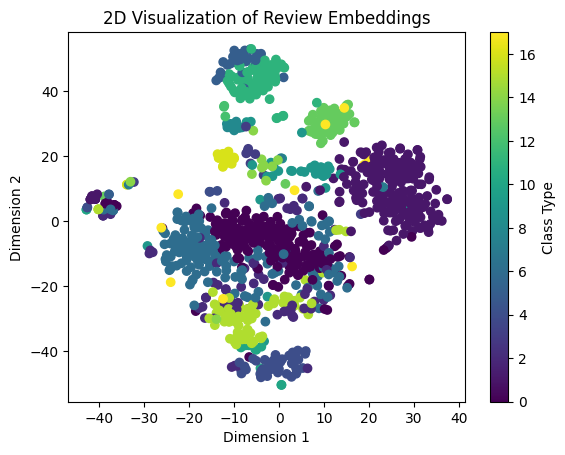

In [54]:
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c = class_type_encoded, cmap="viridis")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("2D Visualization of Review Embeddings")
plt.colorbar(label="Class Type")
plt.show()


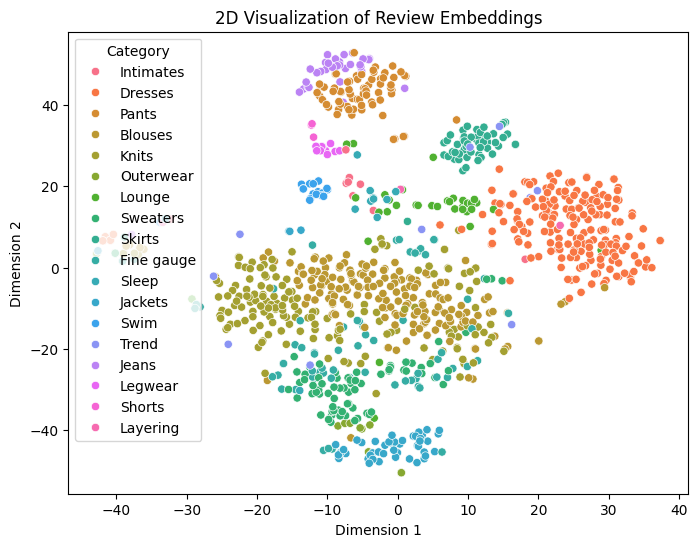

In [56]:
#Another way to plot with Seaborn:
import seaborn as sns
import pandas as pd

# Convert data into a Pandas DataFrame for Seaborn
df = pd.DataFrame({
    "Dimension 1": embeddings_2d[:, 0],
    "Dimension 2": embeddings_2d[:, 1],
    "Category": class_type
})

# Use seaborn's scatter plot with categorical hue
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="Dimension 1", y="Dimension 2", hue="Category")
plt.title("2D Visualization of Review Embeddings")
plt.show()

General observation: It seems like reviews about similar types of items seem to cluster together

In [49]:
list(set(class_type))

['Sleep',
 'Pants',
 'Knits',
 'Lounge',
 'Swim',
 'Jeans',
 'Layering',
 'Jackets',
 'Shorts',
 'Sweaters',
 'Dresses',
 'Outerwear',
 'Fine gauge',
 'Blouses',
 'Intimates',
 'Skirts',
 'Trend',
 'Legwear']

9. Create a collection of embeddings for topics of classification

In [60]:
#Define the topics to be embedded
topics = [
    {'label':'fit'},
    {'label':'style'},
    {'label':'quality'},
    {'label':'comfort'},
    {'label':'price'}
]

# Step 2: Create a separate collection for label embeddings
topics_collection = client.get_or_create_collection(name="topics_embeddings")


In [61]:
# Step 5: Extract labels and generate embeddings
topic_labels = [t['label'] for t in topics]  # Extract labels
topic_embeddings = [openai_embed([label])[0] for label in topic_labels]  # Embed each label

# Step 6: Store label embeddings in the ChromaDB collection
topics_collection.add(
    ids=[f"topic_{i}" for i in range(len(topic_labels))],  # Unique IDs for each label
    documents=topic_labels,  # Store label text
    embeddings=topic_embeddings,  # Store label embeddings
    metadatas=[{"label": label} for label in topic_labels]  # Store label metadata
)

print(f"Inserted {len(topic_labels)} label embeddings into 'topics_embeddings' collection.")

Inserted 5 label embeddings into 'topics_embeddings' collection.


In [63]:
topic_labels

['fit', 'style', 'quality', 'comfort', 'price']

In [67]:
len(topic_embeddings[0])

1536

In [70]:
topic_embeddings = np.array(topic_embeddings)

In [71]:
topic_embeddings.shape

(5, 1536)

10. Define a function that takes in the embeddings and finds the most similar

In [72]:
type(embeddings)
embeddings.shape

(1000, 1536)

In [74]:
import numpy as np
from scipy.spatial.distance import cdist

def find_closest_topics(query_vectors, document_embeddings):
    """
    Find the closest topic for each document embedding using cosine distance.

    Parameters:
    - query_vectors (np.array): Shape (5, 1536) - Topic embeddings
    - document_embeddings (np.array): Shape (1000, 1536) - Document embeddings

    Returns:
    - closest_topics (list): List of closest topic indices for each document
    - closest_distances (list): Corresponding distances
    """
    # Compute cosine distances between document embeddings and query vectors
    distances = cdist(document_embeddings, query_vectors, metric="cosine")  # Shape (1000, 5)

    # Find the index of the closest topic for each document
    closest_topic_indices = np.argmin(distances, axis=1)  # Shape (1000,)

    # Get the corresponding minimum distances
    closest_distances = np.min(distances, axis=1)  # Shape (1000,)

    return closest_topic_indices, closest_distances

# Example usage
closest_topics, closest_distances = find_closest_topics(topic_embeddings, embeddings)

# Print the closest topic for the first 5 documents
for i in range(5):
    print(f"Document {i}: Closest Topic Index = {closest_topics[i]}, Distance = {closest_distances[i]:.4f}")

Document 0: Closest Topic Index = 3, Distance = 0.6976
Document 1: Closest Topic Index = 0, Distance = 0.8112
Document 2: Closest Topic Index = 0, Distance = 0.8055
Document 3: Closest Topic Index = 1, Distance = 0.8080
Document 4: Closest Topic Index = 0, Distance = 0.7809


In [75]:
topic_labels

['fit', 'style', 'quality', 'comfort', 'price']

In [76]:
len(closest_topics)

1000

11. Map and re-plot the 2D topic labels

In [77]:
# Define the topic labels
topic_labels = ["fit", "style", "quality", "comfort", "price"]

# Map indices to topic labels
assigned_topic_labels = [topic_labels[i] for i in closest_topics]

# Print the first few mappings
for i in range(5):
    print(f"Document {i}: Closest Topic = {assigned_topic_labels[i]}")

Document 0: Closest Topic = comfort
Document 1: Closest Topic = fit
Document 2: Closest Topic = fit
Document 3: Closest Topic = style
Document 4: Closest Topic = fit


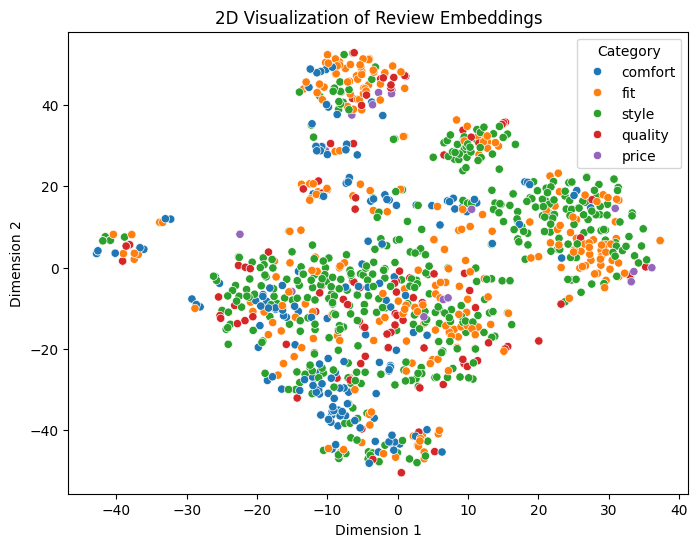

In [80]:
#Another way to plot with Seaborn:
import seaborn as sns
import pandas as pd

# Convert data into a Pandas DataFrame for Seaborn
df = pd.DataFrame({
    "Dimension 1": embeddings_2d[:, 0],
    "Dimension 2": embeddings_2d[:, 1],
    "Category": assigned_topic_labels
})

# Use seaborn's scatter plot with categorical hue
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="Dimension 1", y="Dimension 2", hue="Category")
plt.title("2D Visualization of Review Embeddings")
plt.show()

The 2D separation of topics using these inferred labels is quite muddy, while the meta-data labels do seem to be effective at separating the topicas by type.

12. Find the most similar review to the following text "Absolutely wonderful - silky and sexy and comfortable"

In [82]:
reference_text = "Absolutely wonderful - silky and sexy and comfortable"

result = collection.query(
   query_texts=reference_text,
   n_results=3
)


In [84]:
result

{'ids': [['0', '627', '210']],
 'embeddings': None,
 'documents': [['Review: Absolutely wonderful - silky and sexy and comfortable Division: Initmates, Department: Intimate, Class: Intimates',
   'Review: This is a very comfortable and sexy sleep dress, the way it drapes. i can see that the type of fabric is not suitable for out and about activities and can catch on snags, etc. very easily. once i relegated it to the nightgown category it became my favorite item to wear and lounge in. Division: General Petite, Department: Intimate, Class: Lounge',
   'Review: I have already worn this several times. it is very flattering, lightweight, and easy to wear. dressy but also very soft and comfortable. Division: General, Department: Tops, Class: Fine gauge']],
 'uris': None,
 'data': None,
 'metadatas': [[{'Age': 33,
    'Class Name': 'Intimates',
    'Clothing ID': 767,
    'Department Name': 'Intimate',
    'Division Name': 'Initmates',
    'Positive Feedback Count': 0,
    'Rating': 4,
    '